![]()![](https://cienciadosdados.com/images/2022/09/esquenta_-_Bootcamp_CDP.png)

# <font color='blue'>3#21 Dias - Esquenta para o Bootcamp CDP </font>


# Criando Sistema de Recomendações para o Tripadvisor
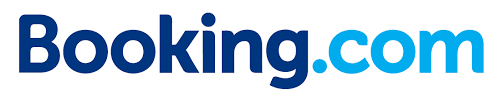

## 1° Problema de Negócio

Você acaba de ser contratado como Cientista de Dados do App "Booking.com".
Seu primeiro projeto deverá ser construir um sistema de recomendações de hotéis para o aplicativo.

## 2° Análise Exploratória de Dados



In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import random


In [2]:
import plotly.graph_objs as go
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='solar')


In [3]:
df = pd.read_csv('Seattle_Hotels.csv', encoding="latin-1")

In [4]:
df.head()

,name,address,desc
0,Hilton Garden Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the..."
1,Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat..."
2,Crowne Plaza Seattle Downtown,"1113 6th Ave, Seattle, WA 98101","Located in the heart of downtown Seattle, the ..."
3,Kimpton Hotel Monaco Seattle,"1101 4th Ave, Seattle, WA98101",What?s near our hotel downtown Seattle locatio...
4,The Westin Seattle,"1900 5th Avenue, Seattle, Washington 98101 USA",Situated amid incredible shopping and iconic a...


In [5]:
print('No dataset', len(df), 'foram encontrados')

No dataset 152 foram encontrados


In [6]:
def print_description(index):
    example = df[df.index == index][['desc', 'name']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Name:', example[1])

In [7]:
print_description(5)

More than just a hotel, The Paramount Hotel Seattle summons the feel of cozy, elegant and luxurious private residence with friendly hosts, the most comfortable beds in Seattle and an award-winning Asian restaurant right downstairs. Youll fall in love with the simple luxury and charm of our boutique hotel, from the warm, inviting wood finishes, comfy seating areas and fireplace in the lobby to the classically decorated rooms and suites appointed with a dash of urban flair. Our central downtown location puts you in good company: one block from the Washington State Convention Center and walking distance to Pike Place Market, the Seattle Art Museum and diverse shopping, cafes and restaurants. There are many reasons The Paramount Hotel is annually ranked among the top five hotels in downtown Seattle, Washington. Why not come find out yours? 
Name: The Paramount Hotel Seattle


In [8]:
print_description(50)

Welcome to the Crowne Plaza Seattle Airport Located across the sky bridge from Seattle Tacoma International Airport and adjacent to the train station, where the light rail train leaves every 12 minutes to downtown Seattle. Take the train to visit the Space Needle, Pike Place Market, Westlake Shopping Center, Nordstroms flag ship store, Century Link, Safeco Field, and the University of Washington.Just beyond our front doors are headquarters of Fortune 500 companies such as Boeing, Microsoft, Amazon, Apple, Google, Tableaux, Facebook and Starbucks. Seattle offers everything from professional sports to hiking up Mt. Rainier, leisure guests planning cruises from Seattle love our hotel's "Park, Stay and Go" package. Join us in Reflections Bar and Grill for a Pacific Northwest dining experience featuring local beers and wine with light bites.Crowne Plaza Seattle Airport has over 12,000 square feet of private event space onsite, with 7 meeting rooms, and two Ballrooms, including our 5,000 sq

In [ ]:
%pip install googletrans==4.0.0-rc1

In [10]:
from googletrans import Translator
import requests

In [11]:
trans = Translator()

trans.translate(" ", dest="pt").text

In [12]:
trans.translate("More than just a hotel, The Paramount Hotel Seattle summons the feel of cozy, elegant and luxurious private residence with friendly hosts, the most comfortable beds in Seattle and an award-winning Asian restaurant right downstairs. Youll fall in love with the simple luxury and charm of our boutique hotel, from the warm, inviting wood finishes, comfy seating areas and fireplace in the lobby to the classically decorated rooms and suites appointed with a dash of urban flair. Our central downtown location puts you in good company: one block from the Washington State Convention Center and walking distance to Pike Place Market, the Seattle Art Museum and diverse shopping, cafes and restaurants. There are many reasons The Paramount Hotel is annually ranked among the top five hotels in downtown Seattle, Washington. Why not come find out yours?Name: The Paramount Hotel Seattle", dest="pt").text

'Mais do que apenas um hotel, o Paramount Hotel Seattle convoca a sensação de residência privada aconchegante, elegante e luxuosa, com anfitriões amigáveis, as camas mais confortáveis de Seattle e um restaurante asiático premiado no andar de baixo.Você se apaixonará pelo simples luxo e charme do nosso hotel boutique, desde acabamentos de madeira quentes e convidativos, áreas confortáveis de estar e lareira no saguão até os quartos e suítes classicamente decorados, designados com uma pitada de talento urbano.Nossa localização central no centro coloca você em boa companhia: a uma quadra do Centro de Convenções do Estado de Washington e a uma curta distância do Pike Place Market, do Seattle Art Museum e das diversas compras, cafés e restaurantes.Há muitas razões pelas quais o Paramount Hotel está classificado anualmente entre os cinco principais hotéis do centro de Seattle, Washington.Por que não vir descobrir o seu? Nome: The Paramount Hotel Seattle'

### Visualize Token (vocabulary) Frequency Distribution Before Removing Stop Words

In [13]:
%matplotlib inline
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['desc'], 20)
df1 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df1.groupby('desc').sum()['count'].sort_values().iplot(kind='barh', yTitle='Count', linecolor='black', title='Top 20 words in hotel description before removing stop words')

### Visualize Token (vocabulary) Frequency Distribution After Removing Stop Words

In [14]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['desc'], 20)
df2 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df2.groupby('desc').sum()['count'].sort_values().iplot(kind='barh', yTitle='Count', linecolor='black', title='Top 20 words in hotel description after removing stop words')

### Bigrams (2 termos) Distribuição de frequência antes de remover Stop Word

In [15]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['desc'], 20)
df3 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df3.groupby('desc').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in hotel description before removing stop words')

### Bigrams - Distribuição de frequência depois de remover Stop Word

In [16]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['desc'], 20)
df4 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df4.groupby('desc').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in hotel description After removing stop words')

### Trigrams - Distribuição de frequência antes de remover Stop Word

In [17]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['desc'], 20)
df5 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df5.groupby('desc').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in hotel description before removing stop words')

## Trigrams - Distribuição de frequência depois de remover Stop Word

In [18]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['desc'], 20)
df6 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
df6.groupby('desc').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in hotel description after removing stop words')

### Hotel Description - Comprimento da Descrição do Hotel 

In [24]:
df['word_count'] = df['desc'].apply(lambda x: len(str(x).split()))

In [ ]:
df

In [26]:
desc_lengths = list(df['word_count'])

print("Number of descriptions:",len(desc_lengths),
      "\nAverage word count", np.average(desc_lengths),
      "\nMinimum word count", min(desc_lengths),
      "\nMaximum word count", max(desc_lengths))

Number of descriptions: 152 
Average word count 156.94736842105263 
Minimum word count 16 
Maximum word count 494


In [27]:
%matplotlib inline
df['word_count'].iplot(
    kind='hist',
    bins = 50,
    linecolor='black',
    xTitle='word count',
    yTitle='count',
    title='Contagem de Palavras na descrição dos Hotéis')

In [31]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### 3° Pre-processing dos Dados - hotel description text 



In [32]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: o text é uma string
        
        return: o output será a versão limpa
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df['desc_clean'] = df['desc'].apply(clean_text)

In [33]:
def print_description(index):
    example = df[df.index == index][['desc_clean', 'name']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Name:', example[1])
print_description(7)

downtown seattle destination hotel steps everywhere want seattle style motif local welcome libation rooftop lounge views across city touchstones areas sweeping landscape rich arts music culture infuse surroundings newly renovated rooms feel like modern residences natural hardwoods colors inspired pacific northwest youll find regions culinary bounty reflected menus frolik kitchen + cocktails adjoining fifth floor patio join us 5th avenue pike union shopping pike place market waterfront convention center seattle monorail light rail airport stroll away
Name: Motif Seattle


In [34]:
def print_description(index):
    example = df[df.index == index][['desc_clean', 'name']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Name:', example[1])
print_description(2)

located heart downtown seattle awardwinning crowne plaza hotel seattle downtown offers exceptional blend service style comfort youll notice cool comfortable unconventional touches set us apart soon step inside marvel stunning views city lights relaxing new sleep advantage beds enjoy complimentary wireless internet throughout hotel amenities help relax like temple spa sleep tight amenity kits featuring lavender spray lotions help rejuvenate unwind enjoy invigorating workout 24hour fitness center get dining suggestions expert concierge savor sumptuous cuisine regatta bar grille restaurant enjoy happy hour lounge daily 4pm 7pm monthly drink specials come experience emerald city offer us
Name: Crowne Plaza Seattle Downtown


In [ ]:
print_description(100)

In [36]:
df.set_index('name', inplace = True)

In [37]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['desc_clean'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [38]:
indices = pd.Series(df.index)

In [ ]:
indices[:50]

# # 4° Máquina Preditiva com Machine Learning

In [40]:
def recommendations(name, cosine_similarities = cosine_similarities):
    
    recommended_hotels = []
    
    # obtendo o índice do hotel que corresponde ao nome
    idx = indices[indices == name].index[0]

    # criando uma série com as pontuações de similaridade em ordem decrescente
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)

    # obtendo os índices dos 10 hotéis mais semelhantes, exceto ele próprio
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # preencher a lista com os nomes dos 10 principais hotéis correspondentes
    for i in top_10_indexes:
        recommended_hotels.append(list(df.index)[i])
        
    return recommended_hotels

In [41]:
recommendations('Hilton Seattle Airport & Conference Center')

['Embassy Suites by Hilton Seattle Tacoma International Airport',
 'DoubleTree by Hilton Hotel Seattle Airport',
 'Seattle Airport Marriott',
 'Motel 6 Seattle Sea-Tac Airport South',
 'Econo Lodge SeaTac Airport North',
 'Four Points by Sheraton Downtown Seattle Center',
 'Knights Inn Tukwila',
 'Econo Lodge Renton-Bellevue',
 'Hampton Inn Seattle/Southcenter',
 'Radisson Hotel Seattle Airport']

As seguintes recomendações foram feitas pelo Google:"Hilton Seattle Airport & Conference Center":

![image.png](attachment:image.png)

As seguintes recomendações foram feitas pelo Tripadvisor para "Hilton Seattle Airport & Conference Center":

![image.png](attachment:image.png)

Try a bed and breakfast

In [42]:
recommendations("The Bacon Mansion Bed and Breakfast")

['11th Avenue Inn Bed and Breakfast',
 'Shafer Baillie Mansion Bed & Breakfast',
 'Chittenden House Bed and Breakfast',
 'Gaslight Inn',
 'Bed and Breakfast Inn Seattle',
 'Silver Cloud Hotel - Seattle Broadway',
 'Hyatt House Seattle',
 'Mozart Guest House',
 'Quality Inn & Suites Seattle Center',
 'MarQueen Hotel']

The following are recommended by **Google** for "The Bacon Mansion Bed and Breakfast":

![image.png](attachment:image.png)

Cool! Almost identical.

Essas foram as recomendações do **Tripadvisor** para "The Bacon Mansion Bed and Breakfast".

![image.png](attachment:image.png)

### FIM!
## Links das Redes Sociais Ciência dos Dados
## [LinkTree](https://linktr.ee/cienciadosdados)

![](https://cienciadosdados.com/images/thumbs/seta-laranja.png) 

